# Extracellular
Generates data from simulated extracellular recordings for studying with spike sorting etc. We run the same simulation as in DryWetLab, but use extracellular measurements to count spikes and check interspike interval distribution.

In [1]:
%matplotlib nbagg
from tqdm import tqdm_notebook as tqdm
import itertools

import numpy as np
from scipy import stats, signal, ndimage
import scipy.integrate as spint
import scipy.interpolate as spolate 
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from colorednoise import powerlaw_psd_gaussian as gen_noise
from braingeneers import drylab

In [2]:
# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 950

# Timestep
dt = 1

# How much stronger inhibitory connections are than excitatory ones.
inhibition_factor = 2

# Used for constructing nonhomogeneous neural populations,
# interpolated between two types based on the value of
# r ∈ [0,1]. Excitatory neurons go from Regular Spiking
# to Chattering, while inhibitory neurons go from
# Low-Threshold Spiking to Late Spiking models over the
# same range. Adapted from Izhikevich's writings.
r = np.random.rand(N) # unitless
l = np.ones(N) # unitless

# a : 1/ms recovery time constant of membrane leak currents
a = np.hstack((0.03*l[:Ne], 0.03 + 0.14*r[Ne:]))
# b : nS recovery conductivity
b = np.hstack((-2 + 3*r[:Ne]**2, 8 - 3*r[Ne:]))
# c : mV voltage of the downstroke
c = np.hstack((-50 + 10*r[:Ne]**2, -53 + 8*r[Ne:]))
# d : pA instantaneous increase in leakage during downstroke
d = np.hstack((100 + 50*r[:Ne]**2, 20 + 80*r[Ne:]))
# C : pF membrane capacitance
C = np.hstack((100 - 50*r[:Ne]**2, 100 - 80*r[Ne:]))
# k : nS/mV Na+ voltage-gated channel conductivity parameter
k = np.hstack((0.7 + 0.8*r[:Ne]**2, 1 - 0.7*r[Ne:]))
# mV : resting membrane voltage
Vr = np.hstack((-60*l[:Ne], -56 - 10*r[Ne:]))
# mV : threshold voltage at u=0
Vt = np.hstack((-40*l[:Ne], -42 + 2*r[Ne:]))

# tau : ms time constant of synaptic current
tau = 20

# Sij : pA total EPSC generated in neuron i when neuron j fires.
mu, sigma = -0.702, 0.9355  # taken from Song (2005).
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
S *= np.median(C / tau)
S[:,Ne:] *= -inhibition_factor
S[Ne:,:Ne] *= 2 # make excitatory input to inhibitory cells stronger

excitatory = np.arange(N) < Ne
inhibitory = np.arange(N) >= Ne

# XY : um planar positions of the cells
XY = 70 * np.random.rand(2,N)

# DryLab MEA
This records data from the organoid with the MEA from braingeneers.drylab, which doesn't have any kind of time delay. It uses the relation $I = C\frac{\mathrm{d}V}{\mathrm{d}t}$.

In [ ]:
tmax = 1001

n = drylab.Organoid(XY=XY, S=S*2, tau=tau,
                    a=a, b=b, c=c, d=d,
                    k=k, C=C, Vr=Vr, Vt=Vt)

n_probes = 8
theta = np.linspace(0, 2*np.pi, num=n_probes+1)[:-1]
points = np.array([np.cos(theta), np.sin(theta)]) * 30 + 35
u = drylab.ElectrodeArray(points=points, activation=None, radius=1)
u.insert(n, Vr, 1/C)
probe_closest_to = np.argmax(u.M, axis=1)

# 1/f noise with RMS value 50 pA.
pinks = 50*gen_noise(size=(N,tmax), exponent=1)

n.reset()

firings = [] 
VUIs = np.zeros((tmax,3,N))
currents = np.zeros((tmax, N))
states = np.zeros((tmax, n_probes))
ground_truth_spikes = [[] for _ in range(n_probes)]
for t in tqdm(range(tmax)):
    
    Vprev = n.V.copy()
    _, fired = n.step(pinks[:,t])
    n.V[n.V > 30] = 30
    
    for i in range(N):
        if fired[i]:
            firings.append((t,i))
    
    for cell in fired.nonzero()[0]:
        ground_truth_spikes[probe_closest_to[cell]].append(t)
    
    # Assuming cells are points, this is the amount of charge 
    # that must have crossed the membrane in the last timestep
    # in order for the voltage to have changed by the amount
    # that it did. Then divide by dt to get the current.
    currents[t,:] = n.C*(Vprev - n.V) / dt
    states[t,:] = u.Vprobe()

ground_truth_spikes = [np.array(spikes) 
                       for spikes in ground_truth_spikes]
firings = np.array(firings)

<IPython.core.display.Javascript object>


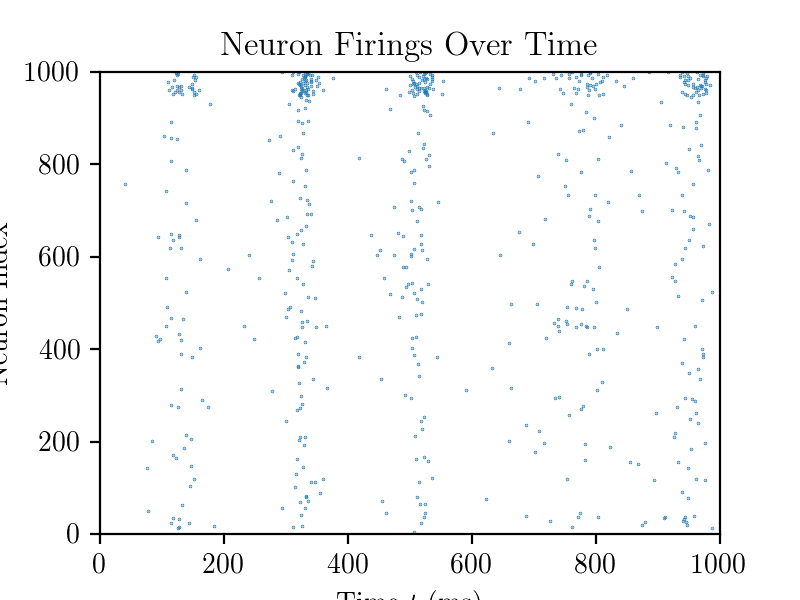

(0, 1000)

In [325]:
plt.figure(figsize=(4,3))
plt.plot(firings[:,0], firings[:,1], '.', markersize=0.5)
plt.title('Neuron Firings Over Time')
plt.xlabel('Time $t$ (ms)')
plt.ylabel('Neuron Index')
plt.xlim([0,tmax-1])
plt.ylim([0,1000])
# plt.savefig('firings.png', dpi=300, bbox_inches='tight') and None

# Direct Diffusion
Instead of computing this nasty analytic solution that takes forever, let's try propagating the diffusion equation forward in time with a Gaussian blur of radius $D\,\mathrm{d}t$. Time is now quantized, but that shouldn't hurt much. The diffusion constant is the value for $\text{Cl}^-$ from [an online table](https://biofilmbook.hypertextbookshop.com/public_version/artifacts/tables/Module_004/Table4-1_DiffCoeffH2O.htm). This value was chosen because I needed *something* and this is the first electrophysiologically important ion I found a value for.

In [326]:
D = 2 # Diffusion constant, um^2 / ms

# Tensor product grid in micron units.
X = Y = np.linspace(0,70, 101)
dx, dy = X[1] - X[0], Y[1] - Y[0]

# Areal charge distribution, in fC / um^3
rho = np.zeros(X.shape + Y.shape)

# Distance in microns between each probe point 
# and each point of the grid. 
r = np.sqrt((X[:,None] - points[0,:,None,None])**2 +
            (Y[None,:] - points[1,:,None,None])**2)

# Force minimum value to be half the size of a grid
# point since there's no meaning to anything smaller.
min_r = np.sqrt((dx**2 + dy**2))/2
r = np.maximum(r, min_r)

# A factor to divide the integral by to calculate the
# potential due to the charge distribution. Normally, 
# this should be 4pi * permittivity, but here I get  
# the right value if it's 10^6 times larger than that.
# BUUUUUTTTT WHYYYYYYY??????
# The problem is NOT units! If I convert to all SI, 
# everything is still too big by the same factor.
eps_factor = 4 * np.pi * 80 * 8.854187 # pF/um

# Quantize each neuron position to the nearest grid point.
XYgrid = np.int32(np.round(XY.T / [dx, dy])).T

# Standard deviation of the Gaussian blur which approximates
# a single timestep of the diffusion process. It should be
# sqrt(D dt), but for the function we're using, it needs to be
# expressed in grid points rather than real units, so divide
# by the grid spacing.
sigma = np.sqrt(D*dt)/np.array([dx, dy])
print('Kernel size', np.int32(4*sigma))

states2 = np.zeros((tmax, n_probes))
for t in tqdm(range(tmax)):
    # Use the current to get quantity of injected charge, 
    # which must be in fC = pA ms. Then divide by the area
    # of the current grid cell for AREAL charge density.
    indices = zip(XYgrid[0,:], XYgrid[1,:])
    for i,idx in enumerate(indices):
        rho[idx] += currents[t,i]*dt / (dx*dy)
    
    # This Gaussian blur approximates diffusion. Also assume 
    # that charge distribution is neutral outside the region.
    rho = ndimage.gaussian_filter(rho, sigma=sigma, mode='constant')
    
    # For each probe, find the voltage by integrating the point
    # charges contributed by the areal charge density rho.
    states2[t,:] = spint.simps(spint.simps(rho/r, Y), X) / eps_factor
    

Kernel size [8 8]


<IPython.core.display.Javascript object>


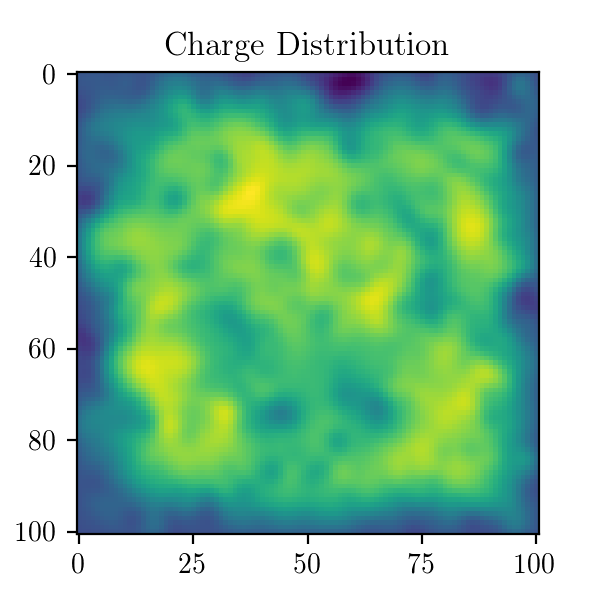

In [327]:
plt.figure(figsize=(3,3))
plt.imshow(rho)
plt.title('Charge Distribution')
plt.savefig('chargedist.png', dpi=300, bbox_inches='tight')

# Sanity Check
Plot the simulation results in terms of both probe voltages and spectrum. We compare the extracellular voltages generated by assuming instantaneous propagation with $1/r$ falloff (in the variable `states`) vs. solving the diffusion equation.

<IPython.core.display.Javascript object>


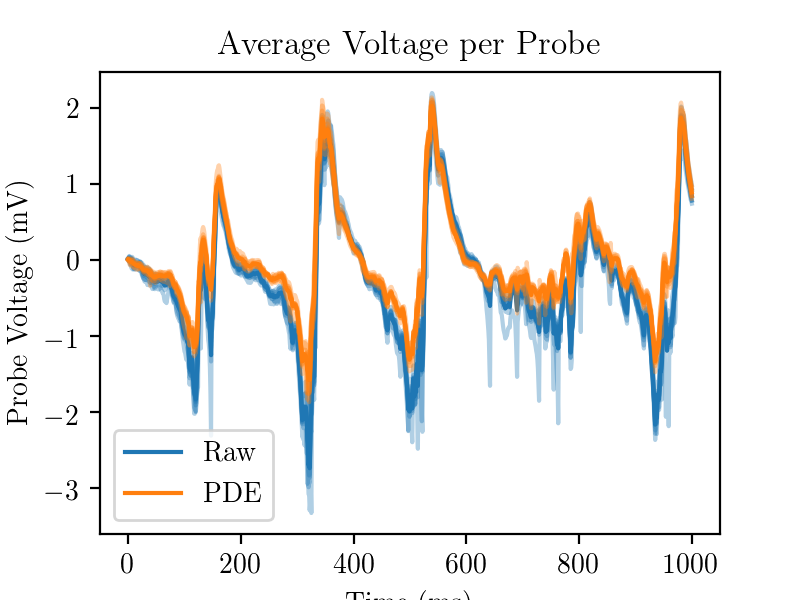

In [328]:
plt.figure(figsize=(4,3))

for probe in range(n_probes):
    plt.plot(states[:,probe], color='C0', alpha=1/np.sqrt(n_probes))
plt.plot(states.mean(axis=1), label='Raw')

for probe in range(n_probes):
    plt.plot(states2[:,probe], color='C1', alpha=1/np.sqrt(n_probes))
plt.plot(states2.mean(axis=1), label='PDE')

plt.legend()
plt.title('Average Voltage per Probe')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (mV)')
None

In [269]:
freq, psds = signal.welch(states.T, 1000)
freq2, psds2 = signal.welch(states2.T, 1000)

<IPython.core.display.Javascript object>


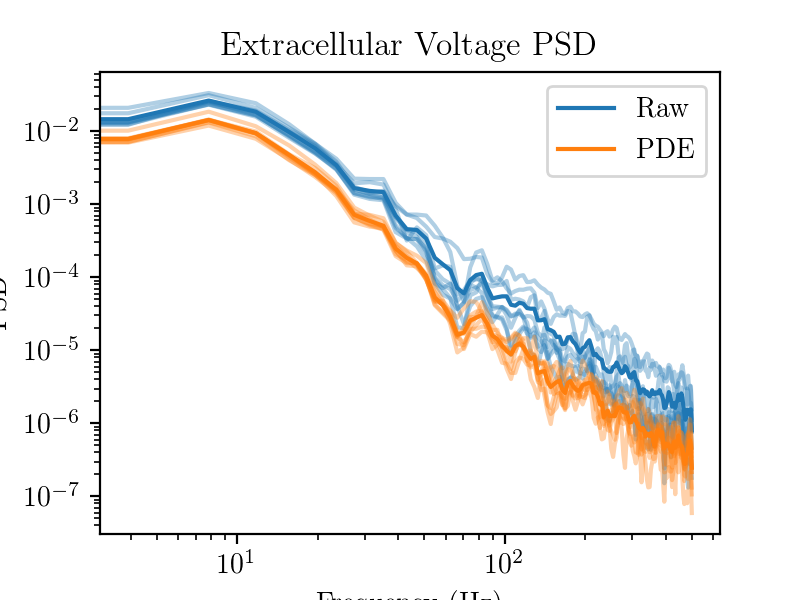

In [329]:
plt.figure(figsize=(4,3))

for probe in range(n_probes):
    plt.loglog(freq, psds[probe,:], 
               color='C0', alpha=1/np.sqrt(n_probes))
plt.loglog(freq, psds.mean(axis=0), label='Raw')

for probe in range(n_probes):
    plt.plot(freq2, psds2[probe,:], 
             color='C1', alpha=1/np.sqrt(n_probes))
plt.loglog(freq2, psds2.mean(axis=0), label='PDE')

plt.legend()
plt.title('Extracellular Voltage PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
None

# Filtering
Electrophysiological data usually bandpass filters over something like 250Hz to 3kHz to remove LFPs. The sampling rate is only 1kHz here though, so there's no need for the high-cut part, just a high-pass at 250Hz.

In [330]:
def butter_highpass(cutoff, fs, order=5):
    return signal.butter(order, 2*cutoff/fs, analog=False,
                         btype='high', output='sos')

In [331]:
sos = butter_highpass(100, fs=1000, order=3)
statesf = signal.sosfilt(sos, states2.T).T

<IPython.core.display.Javascript object>


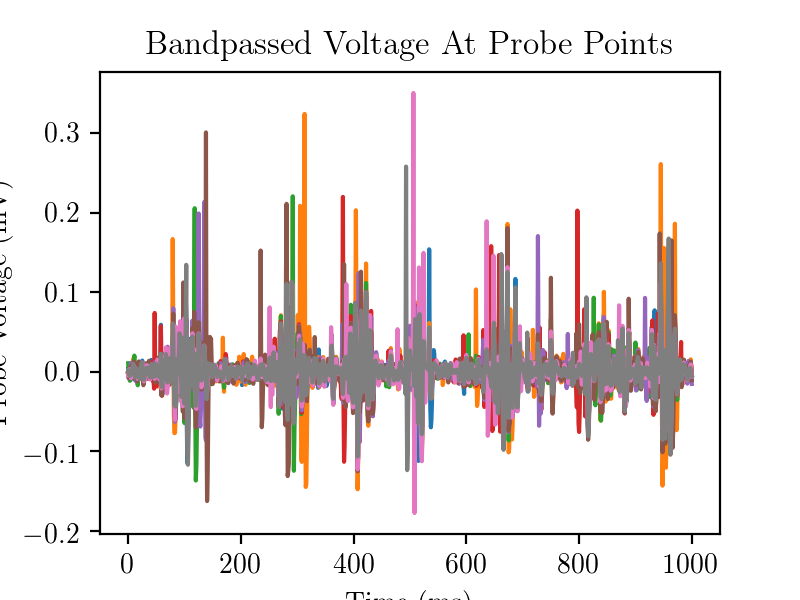

In [332]:
plt.figure(figsize=(4,3))
plt.plot(range(tmax), states2f)
plt.title('Bandpassed Voltage At Probe Points')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (mV)')
None

# Rudimentary Spike Sorting
Use the same simple threshold-based method as Keith to find the spikes in both of those recordings, and compare them with the ground truth.

In [338]:
def find_spikes(x, threshold=20e-3, time_axis=0):
    """
    Finds spikes, where the voltage dips below a negative
    threshold and returns their onset times.
    """
    return (np.diff(np.int32(x < -threshold), 
                    axis=time_axis) == 1).nonzero()

def find_spikes_by_channel(x, *args, **kwargs):
    """
    Find spikes per channel (must be on the last axis).
    """
    return [find_spikes(x[:,channel], *args, **kwargs)[0]
            for channel in range(x.shape[-1])]

In [339]:
spikes_per_channel = find_spikes_by_channel(statesf)

<IPython.core.display.Javascript object>


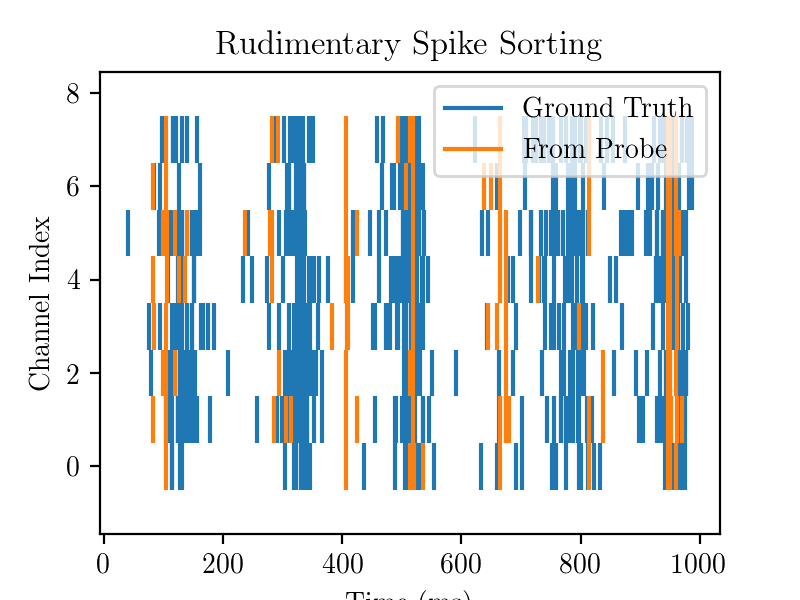

In [340]:
plt.figure(figsize=(4,3))
plt.plot([], [], label='Ground Truth')
plt.plot([], [], label='From Probe')
plt.eventplot(ground_truth_spikes)
# plt.eventplot(spikes_per_channel, color='C1')
plt.eventplot(spikes_per_channel2, color='C1')
plt.legend()
plt.title('Rudimentary Spike Sorting')
plt.xlabel('Time (ms)')
plt.ylabel('Channel Index')
plt.savefig('spiketimes.png', dpi=300, bbox_inches='tight')

In [341]:
# Make a list of interspike intervals from all channels.
intervals = itertools.chain.from_iterable(
    np.diff(spikes_per_channel[channel])
    for channel in range(8))
intervals = np.array(list(intervals))

<IPython.core.display.Javascript object>


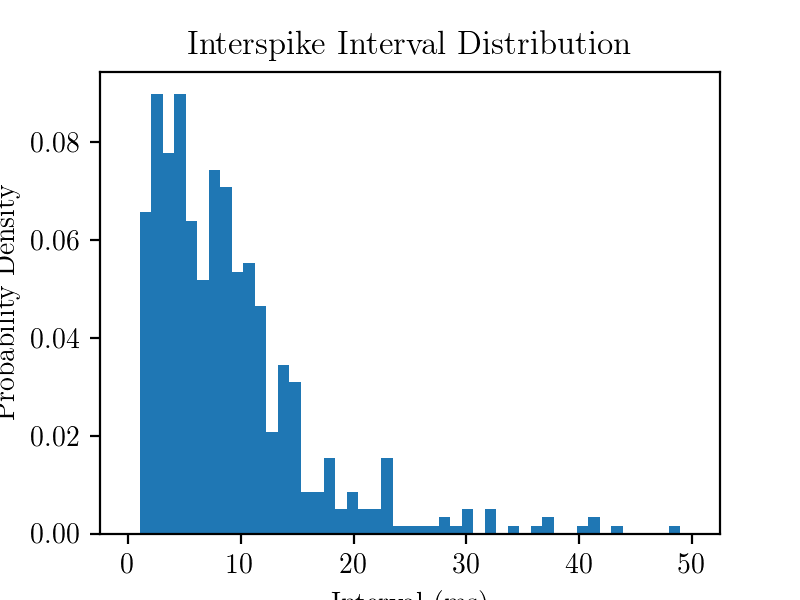

In [342]:
plt.figure(figsize=(4,3))
plt.hist(intervals, list(np.linspace(0,50)) + [np.inf], density=True)
plt.title('Interspike Interval Distribution')
plt.xlabel('Interval (ms)')
plt.ylabel('Probability Density')
None

# Probe Visualization
Just for fun, here's each cell colored according to which probe it's closest to and how much it contributes to that probe.

<IPython.core.display.Javascript object>


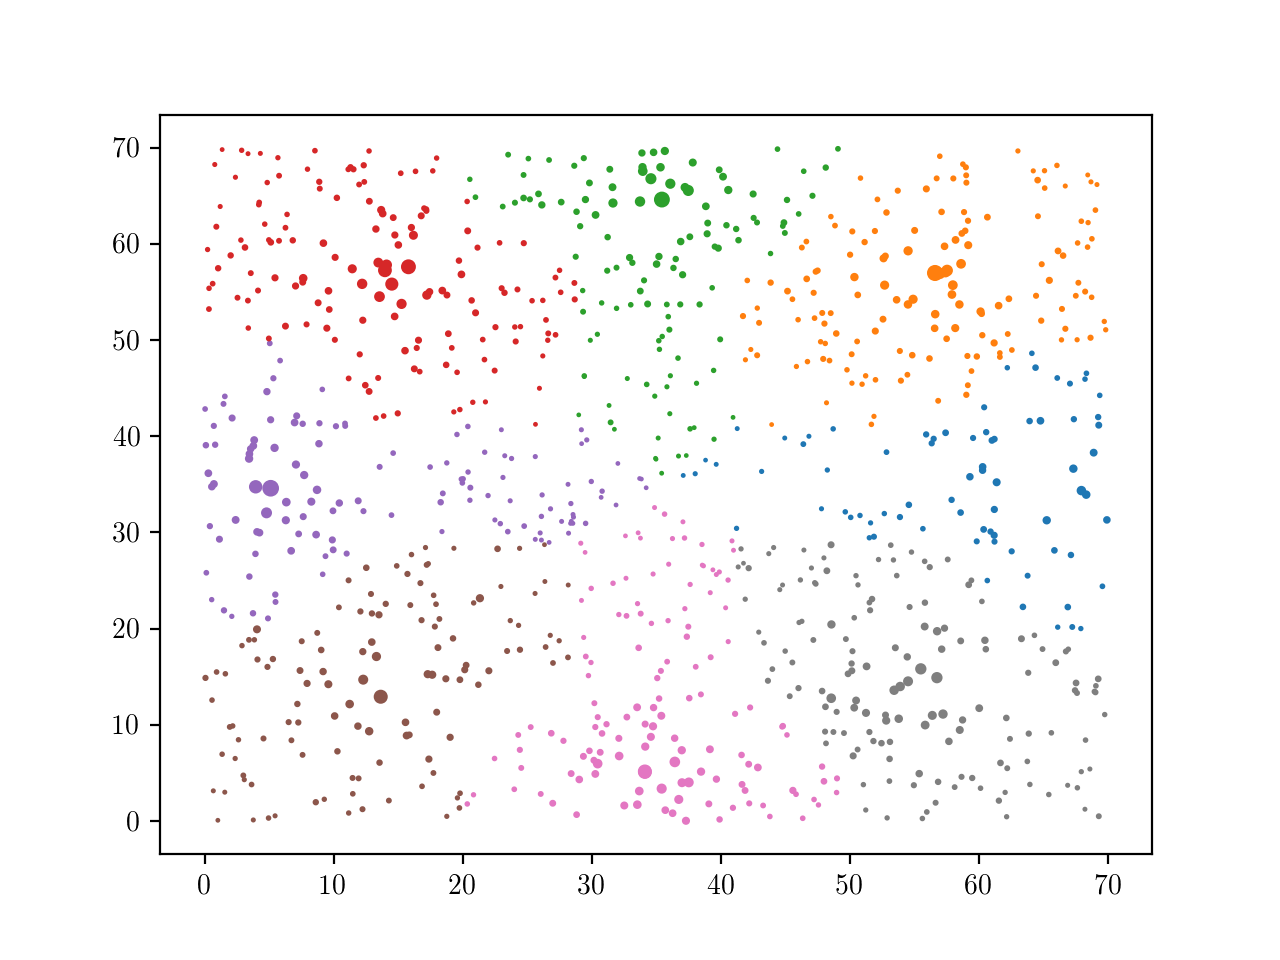

In [343]:
plt.figure()
colors = ['C'+str(i) for i in probe_closest_to]
plt.scatter(n.XY[0,:], n.XY[1,:], c=colors, 
            s=25 * np.max(u.M, axis=1) / np.max(u.M))